In [1]:
import numpy as np

import sys
from parallel import Parallel

sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

/home/yann.zerlaut/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


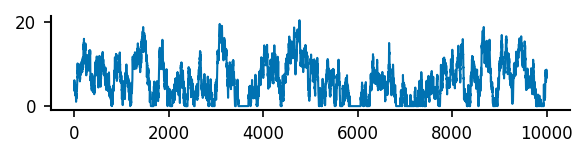

In [2]:
mean, sigma, tau = 5, 5, 10
tstop = 1000
dt = 0.1
OU = np.clip(OrnsteinUhlenbeck_Process(mean, sigma, tau, dt, tstop), 0, np.inf)

fig, ax = pt.figure(figsize=(2,1))
ax.plot(OU)

In [3]:
print(1e3*len(results['spikes'])/results['tstop'])

NameError: name 'results' is not defined

In [5]:
results = np.load('../../data/detailed_model/single_sim.npy', allow_pickle=True).item()
#results = np.load('/tmp/tvRateStim_sim_Martinotti_iBranch_0_stochProcSeed_0_spikeSeed_0.npy', allow_pickle=True).item()
t = np.arange(len(results['Vm_soma']))*results['dt']
fig, AX = pt.figure(axes_extents=[[(1,2)],[(1,1)],[(1,1)]],
                    figsize=(3,1), left=0, bottom=0., hspace=0.)
AX[0].plot(t, results['Vm_soma'], 'tab:purple', label='soma')
AX[0].plot(t, -60+0*t, 'k:')
pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
AX[0].legend(frameon=False, loc=(1, 0.3))

"""
for i, events in enumerate(results['presynaptic_exc_events']):
    AX[1].plot(events, i*np.ones(len(events)), '.', color='g', ms=.5)
for i, events in enumerate(results['presynaptic_inh_events']):
    AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
               color='r', ms=.5)
pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
"""

AX[2].fill_between(t[:-1], 0*t[:-1], results['OU'], color='tab:grey')
#AX[2].fplot(t[:1], results['OU'], color='tab:grey')

pt.set_common_xlims(AX, lims=[t[0], t[-1]])
for ax in AX:
    ax.axis('off')

print(1e3*len(results['spikes'])/results['tstop'])

FileNotFoundError: [Errno 2] No such file or directory: '../../data/detailed_model/single_sim.npy'

(-1000.0, 1000.0)

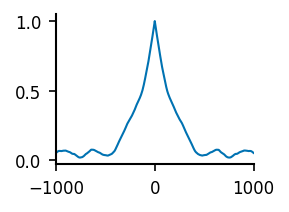

In [10]:
CCF, ts = crosscorrel(results['OU'][::4], results['OU'][::4], 1e3, 4*results['dt'])
plt.plot(ts, CCF)
plt.xlim([-1000,1000])

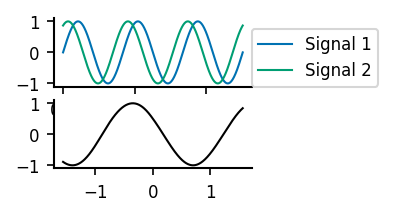

In [51]:
t = np.linspace(0, np.pi*2, int(1000))
Signal1 = np.sin(3*t)
Signal2 = np.cos(3*t-np.pi/6)
_, ax = plt.subplots(2)
ax[0].plot(t, Signal1, label='Signal 1')
ax[0].plot(t, Signal2, label='Signal 2')
ax[0].legend(loc=(1,0))
cr, t_shift = crosscorrel(Signal1, Signal2, np.pi/2., t[1]-t[0])
ax[1].plot(t_shift, cr, 'k-')

In [18]:
from scipy.ndimage import gaussian_filter1d

rate_smoothing = 5. # ms
RESULTS = {}

#cellType, color = 'Martinotti', 'tab:orange'
for cellType, color in zip(['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):

    sim = Parallel(\
            filename='../../data/detailed_model/tvRateStim_sim_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.stochProcSeed)
    nRepeats = int(np.product(sim.spikes.shape)/len(seeds))

    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), nRepeats, int(tstop/dt)+1))
    RESULTS['%s_rates' % cellType] = []
    for s, seed in enumerate(seeds):
        for i, spikes in enumerate(sim.spikes[sim.stochProcSeed==seed]):
            spikes_matrix[s,i,(spikes/dt).astype('int')] = True
        rate = 1e3*gaussian_filter1d(np.mean(spikes_matrix[s,:,:], axis=0)/dt,
                                     int(rate_smoothing/dt))
        RESULTS['%s_rates' % cellType].append(rate)
        print(cellType, 'seed', s, np.mean(rate))

    sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)
    RESULTS['StochProc'] = []
    for s, seed in enumerate(seeds):
        RESULTS['StochProc'].append(sim.OU[sim.stochProcSeed==seed][0])
    RESULTS['t'] = np.arange(len(rate))*dt

Martinotti seed 0 12.577484278144652
Martinotti seed 1 12.362484546894313
Basket seed 0 8.864988918763855
Basket seed 1 8.579989275013407


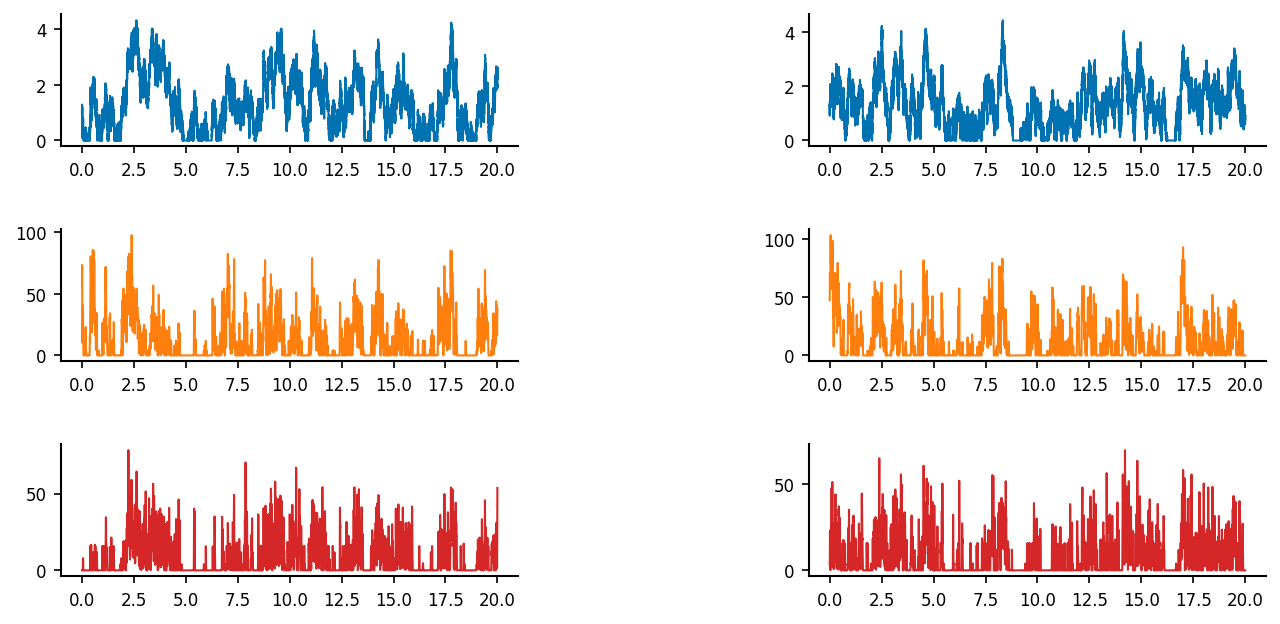

In [14]:
fig, AX = pt.figure(axes=(len(seeds),3), figsize=(2,1.4))

for s, seed in enumerate(seeds):
    AX[0][s].plot(RESULTS['t'][:-1]/1e3, RESULTS['StochProc'][s])
    for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
        AX[1+c][s].plot(RESULTS['t']/1e3, RESULTS['%s_rates' % cellType][s], color)

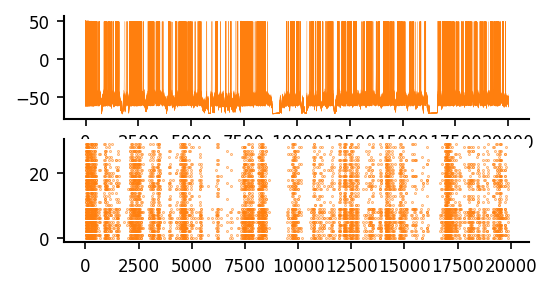

In [30]:
iSeed = 0

sim.fetch_quantity_on_grid('Vm_soma', dtype=list)

Spikes = []
fig, AX = plt.subplots(2, figsize=(4,2))

seed = 1

flat_seeds = sim.stochProcSeed.reshape(np.product(sim.stochProcSeed.shape))
cond = flat_seeds==seed

for i, vm in enumerate(sim.Vm_soma.reshape(np.product(sim.Vm_soma.shape))[cond]):
    t = np.arange(len(vm))*dt
    spikes = find_spikes(t, vm)
    AX[0].plot(t, vm, '-', lw=0.1, color=color)
    AX[1].plot(spikes, i+0*spikes, '.', color=color, ms=0.5)
    Spikes.append(spikes)

In [11]:
spikes_matrix= np.zeros((len(Spikes), int(tstop/dt)+1))
for i, spikes in enumerate(Spikes):
    spikes_matrix[i,(spikes/dt).astype('int')] = True

NameError: name 'tstop' is not defined

7.0741578239693865

In [56]:
tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)


In [57]:
OU = sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)

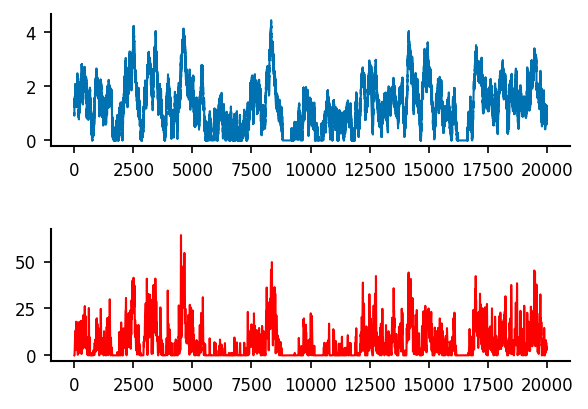

## Compute cross-correlation functions

In [36]:
subsampling = 20
for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    RESULTS['%s_CCs' % cellType] = []
    for s in range(len(seeds)):
        CCF, ts = crosscorrel(RESULTS['%s_rates' % cellType][s][1:][::subsampling],
                              RESULTS['StochProc'][s][::subsampling], 
                              1e3, subsampling*dt)
        RESULTS['%s_CCs' % cellType].append(CCF)
    
RESULTS['CC_StochProc'] = []
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc[::subsampling], sc[::subsampling],
                          1e3, subsampling*dt)
    RESULTS['CC_StochProc'].append(CCF)

### plot

(None, <AxesSubplot:>)

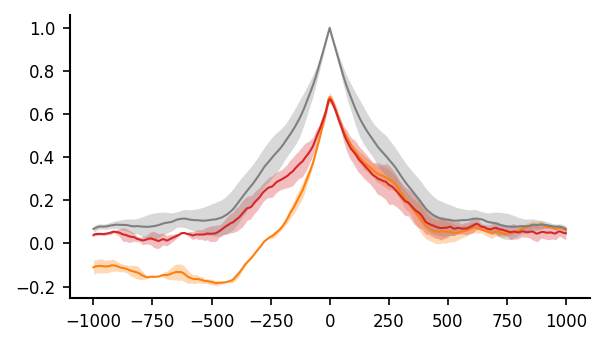

In [37]:
fig, ax = pt.figure(figsize=(2,3))

for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    pt.plot(ts, np.mean(RESULTS['%s_CCs' % cellType], axis=0),
             sy=stats.sem(RESULTS['%s_CCs' % cellType], axis=0),
             color=color, ax=ax)  
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)
    
#pt.set_plot(ax, xlim=[-1000,1000])

In [30]:
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc, sc,
                          1e3, subsampling*RESULTS['dt'])
    RESULTS['CC_StochProc'].append(CCF)
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)


KeyError: 'dt'

In [28]:
RESULTS['CC_StochProc']

[]